**IMPORTS**

In [467]:
import os
import math
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import joblib
import sounddevice as sd
from scipy.signal import butter, lfilter
import soundfile as sf

**RUTAS Y TIPOS DE FRUTAS**

In [468]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
dataset_path     = '../../dataset/audios/test'
original_path    = os.path.join(dataset_path, 'original')
processed_path   = os.path.join(dataset_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

**ORIGINAL TESTS**

In [469]:
original = []
original.extend([os.path.join(original_path, filename) for filename in os.listdir(original_path) if filename.endswith('.wav')])

**PROCESSED TESTS DICT**

In [470]:
processed = []
processed.extend([os.path.join(processed_path, filename) for filename in os.listdir(processed_path) if filename.endswith('.wav')])

**PARAMETROS DEL AUDIO**

In [471]:
FRAME_SIZE = 512# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES GENERALES DE AUDIO**

In [472]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

**FILTERS**

In [473]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

**PROCCESSING OF THE AUDIO FILES FUNCTIONS**

*File naming*

In [474]:
def get_name(original:list):
    return os.path.join(original_path,"test" + f"{len(original) + 1}" + ".wav")

*Processing*

In [475]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

In [476]:
def process(audio_in, audio_out, rms_umbral = 0.043, flux_umbral = 0.096):
    signal, sr, _ = load_audio(audio_in)

    rms = librosa.feature.rms(y = signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)
    rms /= np.max(np.abs(rms))
    trms = librosa.times_like(rms, sr = sr, hop_length = HOP_SIZE, n_fft = FRAME_SIZE)
    trms /= trms[-1]

    flux = spectral_flux(signal)
    flux /= np.max(np.abs(flux))
    fluxframes = range(len(flux))
    tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    tflux /= tflux[-1]
                
    left_index = np.argmax(np.abs(flux) > flux_umbral)
    rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

    tsignal = librosa.times_like(signal, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    tsignal /= tsignal[-1]

    flag      = False
    pad_left  = 0
    pad_rigth = 0
    flag_left  =  False
    flag_rigth =  False
                
    while not flag:
        if rms[0, left_index] > rms_umbral:
            if left_index > pad_left + 15:
                rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                if rms_left <= 0:
                    rms_left = left_index
                flag_left = True
            else:
                pad_left += 15
                left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
        else:
                rms_left = left_index
                flag_left = True

        if rms[0, rigth_index] > rms_umbral:
            if rigth_index < (len(flux) - 1 - pad_rigth-15):
                rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                if rms_rigth >= len(flux):
                    rms_rigth = rigth_index
                flag_rigth = True
            else:
                pad_rigth += 15
                rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
        else:
            rms_rigth = rigth_index
            flag_rigth = True

        flag = flag_left and flag_rigth

    left_index  = min(left_index, rms_left)
    rigth_index = max(rigth_index, rms_rigth)
    mask = tsignal >= tflux[left_index]
    ttrimed = tsignal[mask]
    trimed = signal[mask]
    mask = ttrimed <= tflux[rigth_index]
    ttrimed = ttrimed[mask]
    trimed = trimed[mask]
    sf.write(audio_out, trimed, sr)

**KNN**

In [477]:
def knn(training, test, k_n):
    X           = np.concatenate([v for v in training.values()], axis = 0)
    y           = np.concatenate([[k] * v.shape[0] for k, v in training.items()])
    dist        = cdist(test, X)
    sorted      = np.argsort(dist, axis = 1)
    sorted_k    = sorted[:, 0:k_n]
    predicted   = []
    
    for row in sorted_k:
        labels     = list(y[row])
        prediction = max(set(labels), key = labels.count)
        predicted.append(prediction)
    return predicted

**PLOTTING**

In [478]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [479]:
#3d
def plot_features3d_extra(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(features.keys(),['green','yellow','red','orange','cyan']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        if fruit == 'testing':
            for i, point in enumerate(points):
                ax.text(point[0], point[1], point[2], f"{i}", color='red', fontsize=10) 
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

**FEATURES EXTRACTION**

*Features extraction functions*

In [480]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [481]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [482]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

*function to get the features*

In [483]:
def get_features(signal, sr):
    feature = np.empty((1, 0))

    # BER
    spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    # max
    split_frequency = 600
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.max(np.abs(BER))
    feature = np.append(feature, feat)
    # min
    # 1
    split_frequency = 1900
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 5000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 3
    split_frequency = 9000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # std
    # 1
    split_frequency = 8000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 1000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)

    #ZCR
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    # mean
    feat = np.mean(zcr)
    feature = np.append(feature, feat)
    # maximum
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(np.abs(zcr))
    feature = np.append(feature, feat)
    # std
    cutoff = 10000
    cuton  = 20
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.std(zcr)/np.mean(np.abs(zcr))
    feature = np.append(feature, feat)
    # mean local
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    feat = np.mean(zcr[((len(zcr)*3)//14 - 5) : ((len(zcr)*3)//14 + 5)])
    feature = np.append(feature, feat)
    # local max
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(zcr[((len(zcr)*3)//4 - 10) : ((len(zcr)*3)//4 + 10)])
    feature = np.append(feature, feat)

    # Roll off
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    # mean
    feat = np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)
    # max
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.55)[0]
    feat = np.max(np.abs(roll_off))
    feature = np.append(feature, feat)
    # std
    cutoff = 8500
    cuton = 50
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    feat = np.std(np.abs(roll_off))/np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)

    #MFCCS
    n_mfcc = 4
    # 1
    cuton = 500
    cutoff = 5000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.max(mfccs, axis = 1)
    feature = np.append(feature, feat[3])
    
    # 2
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    feat = np.std(np.abs(mfccs), axis = 1)/np.mean(np.abs(mfccs), axis = 1)
    feature = np.append(feature, feat[3])

    # 3
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    mfccs = mfccs[:, ((mfccs.shape[1]*4) // 5 - 10):((mfccs.shape[1]*4) //5 + 10)]
    feat = np.std(np.abs(mfccs), axis=1) / np.mean(np.abs(mfccs), axis=1)
    feature = np.append(feature, feat[1])

    #envelope
    env = rms(signal, FRAME_SIZE, HOP_SIZE)
    env = env.reshape(-1,)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

**AUFIO RECORGING**

In [505]:
duration = 2.5      # Duración de la grabación en segundos
fs       = 48000    # Frecuencia de muestreo en Hz

print("Grabando...")
data = sd.rec(int(duration * fs), samplerate = fs, channels = 1, dtype = 'int16')
sd.wait()
print("Grabación completa.")

file = get_name(original)
sf.write(file, data, fs)
original.append(file)

Grabando...
Grabación completa.


**PROCESSING**

In [506]:
already_processed = [os.path.basename(audio) for audio in processed]
for audio in original:
    basename =  os.path.basename(audio)
    if basename in already_processed:
        pass
    else:
        audio_out = os.path.join(processed_path, basename)
        process(audio, audio_out)
        processed.append(audio_out)

C:\Users\Juan\AppData\Local\Temp\ipykernel_4644\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


**FEATURE EXTRACTION**

In [507]:
test_features = None
for audio in processed:
    signal, sr, _ = load_audio(audio)
    feature = get_features(signal, sr)
    
    if test_features is not None:
        test_features = np.vstack([test_features, feature])
    else:
        test_features = feature.reshape(1, -1)

C:\Users\Juan\AppData\Local\Temp\ipykernel_4644\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


**LOAD THE REDUCED MODEL**

In [508]:
model        = joblib.load(model_file)
reduced:dict = model['features']
pca          = model['pca']
scaler       = model['scaler']

**TRANSFORM**

In [509]:
scaled_test_features   = scaler.transform(test_features)
reduced_test           = pca.transform(scaled_test_features)

**EXTENSION OF THE FEATURES DICT**

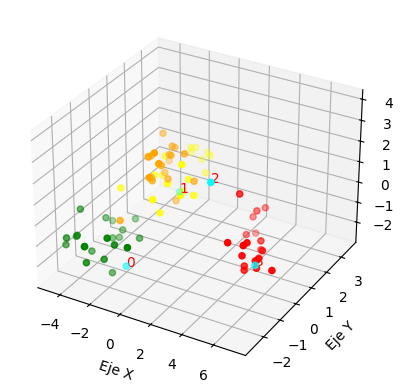

In [510]:
extra               = reduced.copy()
extra['testing']    = reduced_test
plot_features3d_extra(extra)

**PREDICTION**

In [511]:
from prettytable import PrettyTable
prediction  = knn(reduced, reduced_test, 3)
audios      = []
audios      = [os.path.basename(audio) for audio in processed]

table = PrettyTable()
table.field_names = ['audios'] + audios
table.add_row(['prediction']  + prediction)

print(table)

+------------+-----------+-----------+-----------+-----------+
|   audios   | test1.wav | test2.wav | test3.wav | test4.wav |
+------------+-----------+-----------+-----------+-----------+
| prediction |    pera   |   banana  |  naranja  |  manzana  |
+------------+-----------+-----------+-----------+-----------+
